In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path1 = '/content/drive/MyDrive/reshift estimation dataset/cropped_dataset_32x32.h5'
path2 = '/content/drive/MyDrive/reshift estimation dataset/cropped_32x32(2).h5'

In [ ]:
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras import layers , models, datasets, Input
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
with h5py.File(path1 , 'r') as hf:
    images = np.array(hf['images'])
    redshifts = np.array(hf['specz_redshift'])
    redshift_err = np.array(hf['specz_redshift_err'])

In [ ]:
def load_h5_data(filepath):
    with h5py.File(filepath, 'r') as hf:
        images = np.array(hf['images'])
        redshifts = np.array(hf['specz_redshift'])
    return images, redshifts





images1, redshifts1 = load_h5_data(path1)
images2, redshifts2 = load_h5_data(path2)

# Standardizing dataset shapes
print(f"Shape of Dataset 1: {images1.shape}, Redshifts: {redshifts1.shape}")
print(f"Shape of Dataset 2: {images2.shape}, Redshifts: {redshifts2.shape}")

if images1.shape[1] != images2.shape[1]:
    min_channels = min(images1.shape[1], images2.shape[1])
    images1 = images1[:, :min_channels]
    images2 = images2[:, :min_channels]

images = np.concatenate([images1, images2], axis=0)
redshifts = np.concatenate([redshifts1, redshifts2], axis=0)

print(f"Final Merged Dataset Shape: {images.shape}, Redshifts: {redshifts.shape}")


Shape of Dataset 1: (30000, 5, 32, 32), Redshifts: (30000,)
Shape of Dataset 2: (30000, 5, 32, 32), Redshifts: (30000,)
Final Merged Dataset Shape: (60000, 5, 32, 32), Redshifts: (60000,)


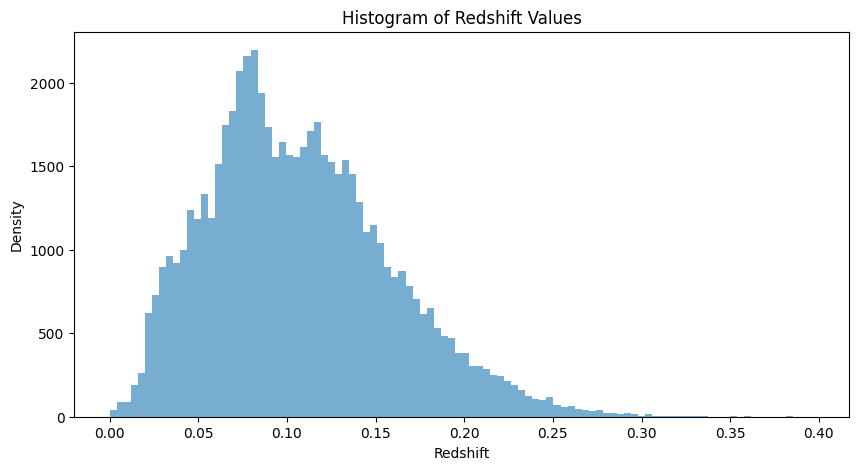

In [ ]:
#plotting histogram of redshift values befoe normalization

plt.figure(figsize=(10, 5))
plt.hist(redshifts, bins=100, alpha=0.6, label="Histogram")
plt.title("Histogram of Redshift Values")
plt.xlabel("Redshift")
plt.ylabel("Density")
plt.show()


In [ ]:
 # From (samples, channels, height, width) to (samples, height, width, channels)
images = np.transpose(images, (0, 2, 3, 1))



images = images / 255
# redshifts = (redshifts - redshifts.min()) /(redshifts.max() - redshifts.min())
scalar = MinMaxScaler()

In [ ]:
X_train , X_test, y_train , y_test = train_test_split(images , redshifts, test_size = 0.2 ,random_state = 42)
#  = train_test_split(redshifts , test_size = 0.2 ,random_state = 42)

y_train = scalar.fit_transform(y_train.reshape(-1, 1))

In [ ]:
# Reshape y_train and y_val to have an explicit shape of (num_samples, 1)
y_train = y_train.reshape(-1, 1)
# y_val = y_val.reshape(-1, 1)


In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)

In [ ]:
# inputs = Input(shape = (32,32,5))

# x = layers.Conv2D(32, (5 , 5), activation='relu', padding='same')(inputs)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Conv2D(64, (5,5), activation='relu', padding='same')(x)
# x = layers.MaxPooling2D((2, 2), padding='same')(x)
# x = layers.Flatten()(x)
# x = layers.Dense(128, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# x = layers.Dense(64, activation='relu')(x)
# x = layers.Dropout(0.5)(x)
# outputs = layers.Dense(1, activation='linear')(x)

# model = models.Model(inputs=inputs, outputs=outputs)
# model.compile(optimizer = 'adam' , loss = 'mean_squared_error' , metrics = ['mae'])
# model.summary()

In [ ]:
inputs = tf.keras.Input(shape=(32, 32, 5))  # Input layer

x = tf.keras.layers.Conv2D(32, (5, 5), activation='relu')(inputs)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Conv2D(64, (5, 5), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(220, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model = models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer = 'adam' , loss = 'mean_squared_error' , metrics = ['mae'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 5)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │           4,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 10, 10, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 220)                 │         352,220 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 220)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │          14,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 421,725 (1.61 MB)

 Trainable params: 421,725 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# model.summary()
history = model.fit(
    X_train, y_train,
    epochs=50,
    validation_split = 0.3,
    batch_size=156,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 13s 35ms/step - loss: 0.0229 - mae: 0.1183 - val_loss: 0.0085 - val_mae: 0.0704
Epoch 2/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0093 - mae: 0.0741 - val_loss: 0.0078 - val_mae: 0.0693
Epoch 3/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - mae: 0.0710 - val_loss: 0.0058 - val_mae: 0.0569
Epoch 4/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0070 - mae: 0.0643 - val_loss: 0.0055 - val_mae: 0.0571
Epoch 5/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0062 - mae: 0.0605 - val_loss: 0.0042 - val_mae: 0.0493
Epoch 6/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0054 - mae: 0.0570 - val_loss: 0.0051 - val_mae: 0.0556
Epoch 7/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0046 - mae: 0.0521 - val_loss: 0.0032 - val_mae: 0.0430
Epoch 8/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0043 - mae: 0.0506 - val_loss: 0.0034 - val_mae: 0.0439
Epoch 9/50
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - 

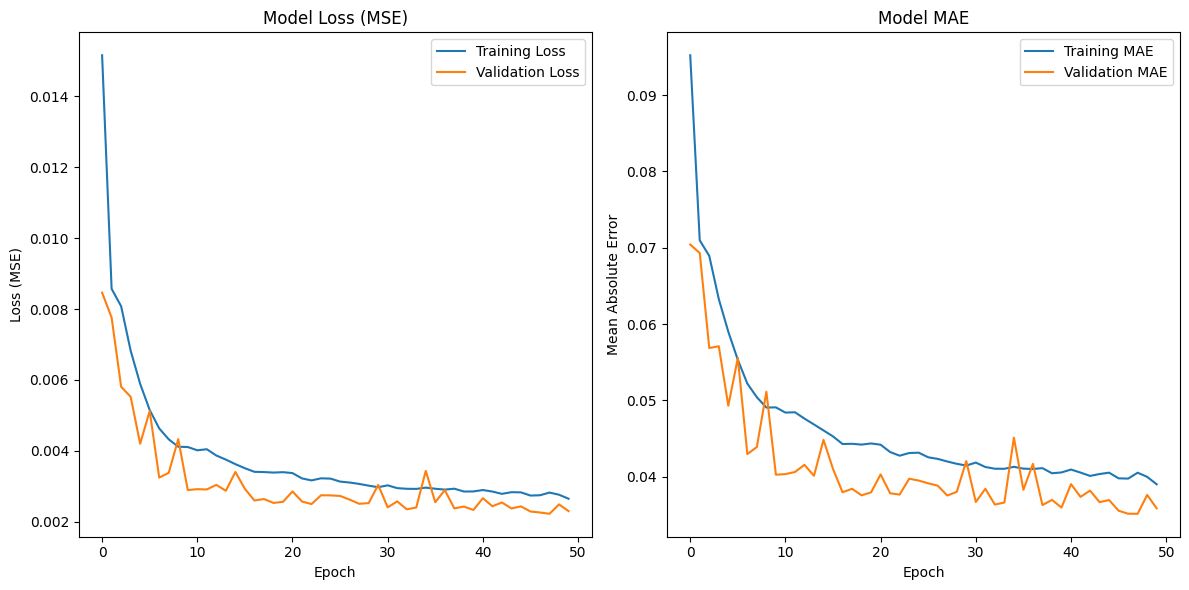

In [ ]:
import matplotlib.pyplot as plt

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss (MSE)')
    plt.ylabel('Loss (MSE)')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    # Plot MAE
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Training MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Model MAE')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# Call the function after training completes
plot_training_history(history)


In [ ]:
# Generate predictions on the validation set
y_tr_pred = scalar.inverse_transform(model.predict(X_train))

# Plot the actual vs predicted redshift
plt.figure(figsize=(6, 6))
plt.scatter(scalar.inverse_transform(y_train), y_tr_pred, alpha=0.5, color='b')  # Scatter plot for actual vs predicted redshifts
plt.plot([0, 0.25], [0, 0.25], 'r--')  # Plot a reference line for perfect predictions
plt.title('Actual vs Predicted Redshift')
plt.xlabel('Actual Redshift')
plt.ylabel('Predicted Redshift')
plt.show()

correlation_coefficient = np.corrcoef(scalar.inverse_transform(y_train).flatten(), y_tr_pred.flatten())[0, 1]
print(f"Correlation Coefficient (train): {correlation_coefficient}")

NameError: name 'model' is not defined

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


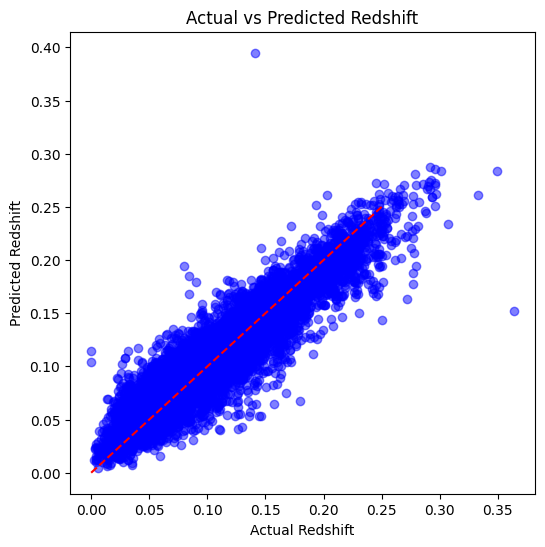

Correlation Coefficient (test): 0.9315947589498317


In [ ]:
# Generate predictions on the validation set
y_ts_pred = scalar.inverse_transform(loaded_model.predict(X_test))

# Plot the actual vs predicted redshift
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_ts_pred, alpha=0.5, color='b')  # Scatter plot for actual vs predicted redshifts
plt.plot([0, 0.25], [0, 0.25], 'r--') # Plot a reference line for perfect predictions
plt.title('Actual vs Predicted Redshift')
plt.xlabel('Actual Redshift')
plt.ylabel('Predicted Redshift')
plt.show()

correlation_coefficient = np.corrcoef(y_test.flatten(), y_ts_pred.flatten())[0, 1]
print(f"Correlation Coefficient (test): {correlation_coefficient}")

In [ ]:
model.save("redshift_model.h5")
print("Model saved as redshift_model.h5")

Model saved as redshift_model.h5


In [ ]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model("redshift_model2.h5")
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
predictions = loaded_model.predict(X_test)

predictions = scalar.inverse_transform(predictions)

print("Predicted Redshifts:\n", predictions)


375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Predicted Redshifts:
 [[0.06028917]
 [0.12227811]
 [0.05270311]
 ...
 [0.05378222]
 [0.09151071]
 [0.08118113]]
